In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

Activations

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

In [3]:
def SSE(actual, predicted):
    sse = np.sum(np.square(actual - predicted))
    losses = np.square(actual - predicted)
    std = np.std(losses)
    return sse / len(actual), std

ANN Implementation

In [4]:
class ANN:
    def __init__(self, input_size, random_initialization, hidden_layer_size=0):
        self.input_size = input_size
        self.hidden_layer_size = hidden_layer_size
        
        if not random_initialization:
            # Normal Xavier initialization
            if hidden_layer_size > 0:
                # Calculate the standard deviation for Xavier initialization
                std_dev_hidden = np.sqrt(2.0 / (input_size + hidden_layer_size))
                self.weights_hidden = np.random.randn(input_size, hidden_layer_size) * std_dev_hidden
                self.bias_hidden = np.zeros(hidden_layer_size)  # Biases to zero

                std_dev_output = np.sqrt(2.0 / (hidden_layer_size + 1))
                self.weights_output = np.random.randn(hidden_layer_size, 1) * std_dev_output
                self.bias_output = np.zeros(1)  # Biases to zero
            else:
                # No hidden layer
                std_dev_output = np.sqrt(2.0 / (input_size + 1))
                self.weights_output = np.random.randn(input_size, 1) * std_dev_output
                self.bias_output = np.zeros(1)  # Biases to zero
        
        else:
            # Random initialization
            if hidden_layer_size > 0:
                # Initialize weights for hidden layer and output layer
                self.weights_hidden = np.random.randn(input_size, hidden_layer_size)
                self.bias_hidden = np.random.randn(hidden_layer_size)
                self.weights_output = np.random.randn(hidden_layer_size, 1)
                self.bias_output = np.random.randn(1)
            else:
                # No hidden layer, direct connection from input to output
                self.weights_output = np.random.randn(input_size, 1)
                self.bias_output = np.random.randn(1)


    def forward(self, x):
        if self.hidden_layer_size > 0:
            self.hidden_activation = sigmoid(np.dot(x, self.weights_hidden) + self.bias_hidden)
            output = np.dot(self.hidden_activation, self.weights_output) + self.bias_output
        else:
            output = np.dot(x, self.weights_output) + self.bias_output
        return output

    def backward(self, x, y, output, learning_rate):
        error = output - y
        d_output_error = 2 * error

        if self.hidden_layer_size > 0:
            d_hidden_error = np.dot(d_output_error, self.weights_output.T) * sigmoid_derivative(np.dot(x, self.weights_hidden) + self.bias_hidden)
            self.weights_output -= learning_rate * np.dot(self.hidden_activation.T, d_output_error)
            self.bias_output -= learning_rate * np.sum(d_output_error, axis=0)
            self.weights_hidden -= learning_rate * np.dot(x.T, d_hidden_error)
            self.bias_hidden -= learning_rate * np.sum(d_hidden_error, axis=0)
        else:
            self.weights_output -= learning_rate * np.dot(x.T, d_output_error)
            self.bias_output -= learning_rate * np.sum(d_output_error, axis=0)

    def train(self, X, Y, epochs, learning_rate):
        loss_history = []
        for _ in tqdm(range(epochs)):
            epoch_losses = []
            for x, y in zip(X, Y):
                output = self.forward(x.reshape(1, self.input_size))
                self.backward(x.reshape(1, self.input_size), y, output, learning_rate)
                epoch_losses.append(((output - y) ** 2).mean())
            loss_history.append(np.mean(epoch_losses))
        return loss_history

    def predict(self, X):
        predictions = []
        for x in X:
            predictions.append(self.forward(x.reshape(1, self.input_size))[0][0])
        return predictions

Load Dataset

In [5]:
def load_dataset(file_path):
    data = np.loadtxt(file_path)
    X = data[:, 0].reshape(-1, 1)
    Y = data[:, 1]
    return X, Y

X_train, Y_train = load_dataset('./data_supervised_learning_project/train1.txt')
X_test, Y_test = load_dataset('./data_supervised_learning_project/test1.txt')

Normalize Data

In [6]:
# Calculate the mean and max using training data only
mean_data_X_train = np.mean(X_train, axis=0)
max_val_X_train = np.max(np.abs(X_train), axis=0)
X_train_normal = (X_train - mean_data_X_train) / max_val_X_train
X_test_normal = (X_test - mean_data_X_train) / max_val_X_train

# Apply the same process for the outputs if necessary
mean_data_Y_train = np.mean(Y_train, axis=0)
max_val_Y_train = np.max(np.abs(Y_train), axis=0)
Y_train_normal = (Y_train - mean_data_Y_train) / max_val_Y_train
Y_test_normal = (Y_test - mean_data_Y_train) / max_val_Y_train

Is it sufficient to use a linear regressor?

100%|██████████| 10000/10000 [00:08<00:00, 1243.16it/s]


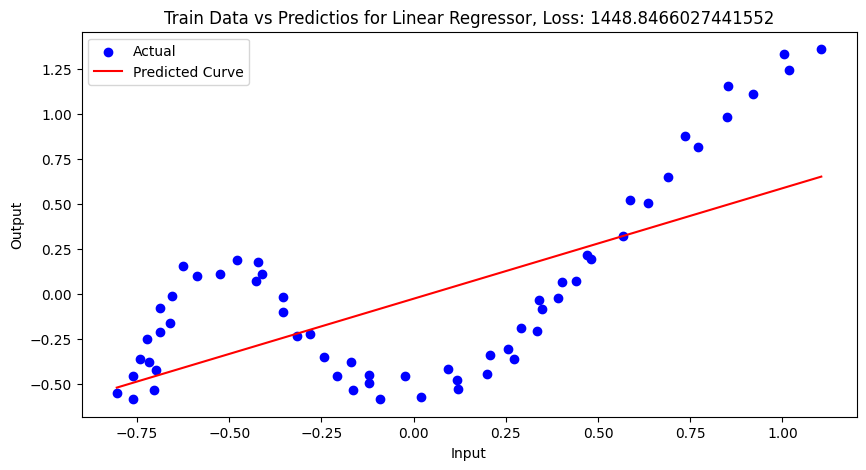

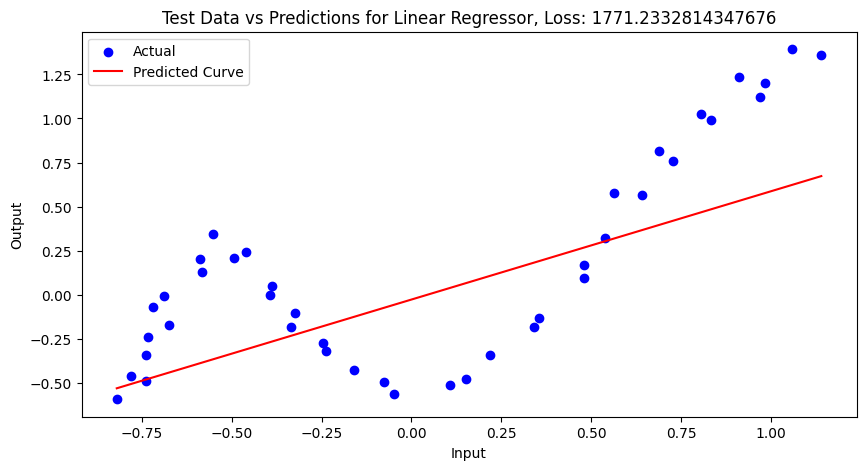

In [21]:
model = ANN(1, True, 0)
loss_history = model.train(X_train_normal, Y_train_normal, 10000, 0.01)

# Train

train_predictions = model.predict(X_train_normal)

plt.figure(figsize=(10, 5))
plt.scatter(X_train_normal, Y_train_normal, color='blue', label='Actual')

# Create a range of input points to plot a smooth curve
X_smooth = np.linspace(X_train_normal.min(), X_train_normal.max(), 500).reshape(-1, 1)
predictions_smooth = model.predict(X_smooth)
train_loss, std = SSE(Y_train_normal, train_predictions)

# Plot the smooth curve of predictions
plt.plot(X_smooth, predictions_smooth, color='red', label='Predicted Curve')
plt.title(f"Train Data vs Predictios for Linear Regressor, Loss: {train_loss * 10**4}")
plt.xlabel('Input') 
plt.ylabel('Output')
plt.legend()
plt.show()

# Test

test_predictions = model.predict(X_test_normal)

plt.figure(figsize=(10, 5))
plt.scatter(X_test_normal, Y_test_normal, color='blue', label='Actual')

# Create a range of input points to plot a smooth curve
X_smooth = np.linspace(X_test_normal.min(), X_test_normal.max(), 500).reshape(-1, 1)
predictions_smooth = model.predict(X_smooth)
test_loss, std = SSE(Y_test_normal, test_predictions)

# Plot the smooth curve of predictions
plt.plot(X_smooth, predictions_smooth, color='red', label='Predicted Curve')
plt.title(f"Test Data vs Predictions for Linear Regressor, Loss: {test_loss * 10**4}")
plt.xlabel('Input') 
plt.ylabel('Output')
plt.legend()
plt.show()

100%|██████████| 10000/10000 [00:13<00:00, 724.54it/s]


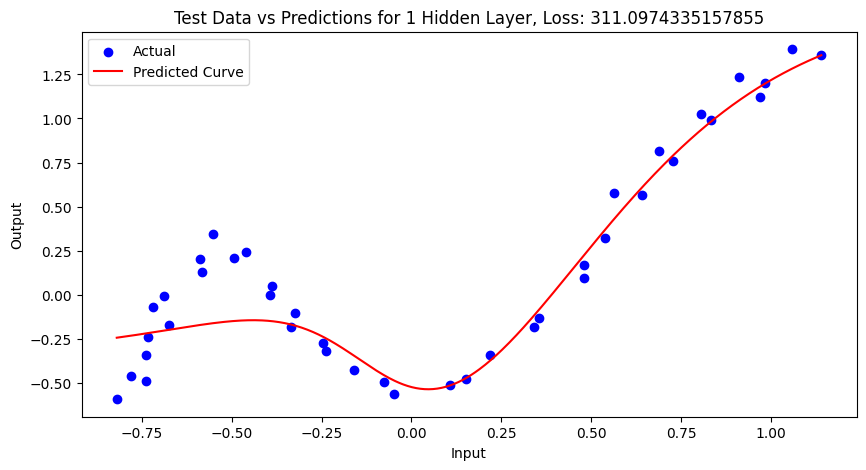

In [25]:
# Is 1 hidden layer sufficent?

model = ANN(1, True, 2)
loss_history = model.train(X_train_normal, Y_train_normal, 10000, 0.01)

test_predictions = model.predict(X_test_normal)

plt.figure(figsize=(10, 5))
plt.scatter(X_test_normal, Y_test_normal, color='blue', label='Actual')

# Create a range of input points to plot a smooth curve
X_smooth = np.linspace(X_test_normal.min(), X_test_normal.max(), 500).reshape(-1, 1)
predictions_smooth = model.predict(X_smooth)
test_loss, std = SSE(Y_test_normal, test_predictions)

# Plot the smooth curve of predictions
plt.plot(X_smooth, predictions_smooth, color='red', label='Predicted Curve')
plt.title(f"Test Data vs Predictions for 1 Hidden Layer, Loss: {test_loss * 10**4}")
plt.xlabel('Input') 
plt.ylabel('Output')
plt.legend()
plt.show()

In [8]:
def plot_results(X, Y, model, title):
    plt.figure(figsize=(6, 3))
    plt.scatter(X, Y, color='blue', label='Actual')
    
    # Create a range of input points to plot a smooth curve
    X_smooth = np.linspace(X.min(), X.max(), 500).reshape(-1, 1)
    predictions_smooth = model.predict(X_smooth)
    
    # Plot the smooth curve of predictions
    plt.plot(X_smooth, predictions_smooth, color='red', label='Predicted Curve')
    plt.title(title)
    plt.xlabel('Input') 
    plt.ylabel('Output')
    plt.legend()
    plt.show()

In [9]:
def evaluate_model(hidden_layer_size, learning_rate, epochs, random_initialization, X_train, Y_train, X_test, Y_test, plot=False, partC=False):
    model = ANN(1, random_initialization, hidden_layer_size)
    loss_history = model.train(X_train, Y_train, epochs, learning_rate)
    loss_scaler = 10**4

    # Calculate loss for the training set
    train_predictions = model.predict(X_train)
    train_loss, train_loss_std = SSE(Y_train, train_predictions)
    train_loss*=loss_scaler
    train_loss_std*=loss_scaler

    # Calculate loss for the test set
    test_predictions = model.predict(X_test)
    test_loss, test_loss_std = SSE(Y_test, test_predictions)
    test_loss*=loss_scaler
    test_loss_std*=loss_scaler

    if random_initialization is False:
        init = "Xavier Init"
    else:
        init = "Random Init" 

    print(f"Hidden units: {hidden_layer_size}, Learning Rate: {learning_rate}, Epochs: {epochs}, {init}")
    print(f"Training Loss: {train_loss:.4f}, Training Loss Std: {train_loss_std:.4f}, Test Loss: {test_loss:.4f}, Test Loss Std: {test_loss_std:.4f}\n")

    # Plot results
    if (plot):
        title = f"LR: {learning_rate}, Epochs: {epochs}, Hidden: {hidden_layer_size}, {init}"
        if partC:
            plot_results(X_train, Y_train, model, title + " - Train")
        else:
            plot_results(X_train, Y_train, model, title + " - Train")
            plot_results(X_test, Y_test, model, title + " - Test")

    return model, loss_history, train_loss, train_loss_std, test_loss, test_loss_std

Testing various configurations

In [10]:
# Configuration
input_size = 1
hidden_layers = [2, 4, 8, 16, 32]
learning_rates = [0.001, 0.01, 0.1]
epoch_settings = [5000, 10000, 50000, 100000]
initializations = [False, True]  # False for Xavier, True for Random


# Model evaluation loop
for hidden_layer_size in hidden_layers:
    print(f"Hidden Layer Size: {hidden_layer_size}")
    for lr in learning_rates:
        for epochs in epoch_settings:
            for init in initializations:
                evaluate_model(hidden_layer_size, lr, epochs, init, X_train_normal, Y_train_normal, X_test_normal, Y_test_normal, False, False)



Hidden Layer Size: 2


100%|██████████| 5000/5000 [00:07<00:00, 701.76it/s]


Hidden units: 2, Learning Rate: 0.001, Epochs: 5000, Xavier Init
Training Loss: 412.1594, Training Loss Std: 552.9392, Test Loss: 553.3155, Test Loss Std: 806.0405



100%|██████████| 5000/5000 [00:06<00:00, 727.03it/s]


Hidden units: 2, Learning Rate: 0.001, Epochs: 5000, Random Init
Training Loss: 412.7480, Training Loss Std: 545.3484, Test Loss: 551.6120, Test Loss Std: 817.8636



100%|██████████| 10000/10000 [00:13<00:00, 722.37it/s]


Hidden units: 2, Learning Rate: 0.001, Epochs: 10000, Xavier Init
Training Loss: 385.7243, Training Loss Std: 563.5175, Test Loss: 505.1510, Test Loss Std: 789.6749



100%|██████████| 10000/10000 [00:13<00:00, 727.47it/s]


Hidden units: 2, Learning Rate: 0.001, Epochs: 10000, Random Init
Training Loss: 391.7653, Training Loss Std: 572.6972, Test Loss: 515.3051, Test Loss Std: 800.0779



100%|██████████| 50000/50000 [01:08<00:00, 727.17it/s]


Hidden units: 2, Learning Rate: 0.001, Epochs: 50000, Xavier Init
Training Loss: 328.7446, Training Loss Std: 482.1926, Test Loss: 414.2631, Test Loss Std: 682.6247



100%|██████████| 50000/50000 [01:08<00:00, 725.96it/s]


Hidden units: 2, Learning Rate: 0.001, Epochs: 50000, Random Init
Training Loss: 302.7715, Training Loss Std: 460.7248, Test Loss: 385.8120, Test Loss Std: 650.0551



100%|██████████| 100000/100000 [02:17<00:00, 726.89it/s]


Hidden units: 2, Learning Rate: 0.001, Epochs: 100000, Xavier Init
Training Loss: 120.0199, Training Loss Std: 170.9917, Test Loss: 166.7339, Test Loss Std: 265.5001



100%|██████████| 100000/100000 [02:17<00:00, 727.70it/s]


Hidden units: 2, Learning Rate: 0.001, Epochs: 100000, Random Init
Training Loss: 123.1993, Training Loss Std: 175.2675, Test Loss: 170.8127, Test Loss Std: 274.7057



100%|██████████| 5000/5000 [00:06<00:00, 726.84it/s]


Hidden units: 2, Learning Rate: 0.01, Epochs: 5000, Xavier Init
Training Loss: 315.7024, Training Loss Std: 469.5525, Test Loss: 404.4224, Test Loss Std: 675.5243



100%|██████████| 5000/5000 [00:06<00:00, 730.68it/s]


Hidden units: 2, Learning Rate: 0.01, Epochs: 5000, Random Init
Training Loss: 357.7389, Training Loss Std: 510.4062, Test Loss: 464.9458, Test Loss Std: 754.4823



100%|██████████| 10000/10000 [00:13<00:00, 725.93it/s]


Hidden units: 2, Learning Rate: 0.01, Epochs: 10000, Xavier Init
Training Loss: 182.5450, Training Loss Std: 262.8102, Test Loss: 245.0264, Test Loss Std: 414.6299



100%|██████████| 10000/10000 [00:13<00:00, 727.87it/s]


Hidden units: 2, Learning Rate: 0.01, Epochs: 10000, Random Init
Training Loss: 134.9394, Training Loss Std: 183.0508, Test Loss: 178.4061, Test Loss Std: 275.8273



100%|██████████| 50000/50000 [01:08<00:00, 729.92it/s]


Hidden units: 2, Learning Rate: 0.01, Epochs: 50000, Xavier Init
Training Loss: 96.7822, Training Loss Std: 139.0971, Test Loss: 114.0124, Test Loss Std: 149.3004



100%|██████████| 50000/50000 [01:08<00:00, 730.09it/s]


Hidden units: 2, Learning Rate: 0.01, Epochs: 50000, Random Init
Training Loss: 95.2231, Training Loss Std: 139.3954, Test Loss: 109.8481, Test Loss Std: 140.2407



100%|██████████| 100000/100000 [02:17<00:00, 728.18it/s]


Hidden units: 2, Learning Rate: 0.01, Epochs: 100000, Xavier Init
Training Loss: 94.8598, Training Loss Std: 139.9971, Test Loss: 107.7748, Test Loss Std: 134.8063



100%|██████████| 100000/100000 [02:16<00:00, 730.05it/s]


Hidden units: 2, Learning Rate: 0.01, Epochs: 100000, Random Init
Training Loss: 95.1519, Training Loss Std: 137.1262, Test Loss: 109.9446, Test Loss Std: 138.3860



100%|██████████| 5000/5000 [00:06<00:00, 731.77it/s]


Hidden units: 2, Learning Rate: 0.1, Epochs: 5000, Xavier Init
Training Loss: 330.4249, Training Loss Std: 609.0186, Test Loss: 514.6010, Test Loss Std: 741.5172



100%|██████████| 5000/5000 [00:06<00:00, 728.74it/s]


Hidden units: 2, Learning Rate: 0.1, Epochs: 5000, Random Init
Training Loss: 331.5057, Training Loss Std: 611.0168, Test Loss: 516.2587, Test Loss Std: 743.8462



100%|██████████| 10000/10000 [00:13<00:00, 731.86it/s]


Hidden units: 2, Learning Rate: 0.1, Epochs: 10000, Xavier Init
Training Loss: 329.2420, Training Loss Std: 606.8264, Test Loss: 512.7861, Test Loss Std: 738.9631



100%|██████████| 10000/10000 [00:13<00:00, 733.03it/s]


Hidden units: 2, Learning Rate: 0.1, Epochs: 10000, Random Init
Training Loss: 183.5076, Training Loss Std: 255.1936, Test Loss: 256.5820, Test Loss Std: 303.8195



100%|██████████| 50000/50000 [01:08<00:00, 730.55it/s]


Hidden units: 2, Learning Rate: 0.1, Epochs: 50000, Xavier Init
Training Loss: 218.7084, Training Loss Std: 334.6823, Test Loss: 322.7205, Test Loss Std: 406.4575



100%|██████████| 50000/50000 [01:08<00:00, 730.14it/s]


Hidden units: 2, Learning Rate: 0.1, Epochs: 50000, Random Init
Training Loss: 218.7084, Training Loss Std: 334.6823, Test Loss: 322.7205, Test Loss Std: 406.4575



100%|██████████| 100000/100000 [02:16<00:00, 730.54it/s]


Hidden units: 2, Learning Rate: 0.1, Epochs: 100000, Xavier Init
Training Loss: 476.5751, Training Loss Std: 691.0126, Test Loss: 688.7839, Test Loss Std: 1029.5920



100%|██████████| 100000/100000 [02:16<00:00, 730.05it/s]


Hidden units: 2, Learning Rate: 0.1, Epochs: 100000, Random Init
Training Loss: 476.5751, Training Loss Std: 691.0126, Test Loss: 688.7839, Test Loss Std: 1029.5920

Hidden Layer Size: 4


100%|██████████| 5000/5000 [00:06<00:00, 728.36it/s]


Hidden units: 4, Learning Rate: 0.001, Epochs: 5000, Xavier Init
Training Loss: 410.1788, Training Loss Std: 589.1341, Test Loss: 545.2815, Test Loss Std: 816.2045



100%|██████████| 5000/5000 [00:06<00:00, 728.61it/s]


Hidden units: 4, Learning Rate: 0.001, Epochs: 5000, Random Init
Training Loss: 397.0581, Training Loss Std: 562.1888, Test Loss: 526.8623, Test Loss Std: 801.7127



100%|██████████| 10000/10000 [00:13<00:00, 729.62it/s]


Hidden units: 4, Learning Rate: 0.001, Epochs: 10000, Xavier Init
Training Loss: 393.4632, Training Loss Std: 577.8376, Test Loss: 517.2866, Test Loss Std: 805.8809



100%|██████████| 10000/10000 [00:13<00:00, 728.84it/s]


Hidden units: 4, Learning Rate: 0.001, Epochs: 10000, Random Init
Training Loss: 401.6694, Training Loss Std: 598.7882, Test Loss: 526.7230, Test Loss Std: 816.0273



100%|██████████| 50000/50000 [01:08<00:00, 728.27it/s]


Hidden units: 4, Learning Rate: 0.001, Epochs: 50000, Xavier Init
Training Loss: 305.3603, Training Loss Std: 431.8174, Test Loss: 384.8434, Test Loss Std: 641.4318



100%|██████████| 50000/50000 [01:08<00:00, 728.63it/s]


Hidden units: 4, Learning Rate: 0.001, Epochs: 50000, Random Init
Training Loss: 103.0669, Training Loss Std: 154.4635, Test Loss: 147.2535, Test Loss Std: 236.3160



100%|██████████| 100000/100000 [02:17<00:00, 728.38it/s]


Hidden units: 4, Learning Rate: 0.001, Epochs: 100000, Xavier Init
Training Loss: 61.5026, Training Loss Std: 110.1159, Test Loss: 92.0128, Test Loss Std: 140.4821



100%|██████████| 100000/100000 [02:17<00:00, 728.94it/s]


Hidden units: 4, Learning Rate: 0.001, Epochs: 100000, Random Init
Training Loss: 64.0289, Training Loss Std: 111.1594, Test Loss: 99.0332, Test Loss Std: 143.9591



100%|██████████| 5000/5000 [00:06<00:00, 728.14it/s]


Hidden units: 4, Learning Rate: 0.01, Epochs: 5000, Xavier Init
Training Loss: 194.3865, Training Loss Std: 252.2983, Test Loss: 245.6174, Test Loss Std: 419.3897



100%|██████████| 5000/5000 [00:06<00:00, 729.40it/s]


Hidden units: 4, Learning Rate: 0.01, Epochs: 5000, Random Init
Training Loss: 80.0786, Training Loss Std: 126.5037, Test Loss: 115.1003, Test Loss Std: 163.7686



100%|██████████| 10000/10000 [00:13<00:00, 728.03it/s]


Hidden units: 4, Learning Rate: 0.01, Epochs: 10000, Xavier Init
Training Loss: 62.5867, Training Loss Std: 109.9581, Test Loss: 90.8727, Test Loss Std: 138.1128



100%|██████████| 10000/10000 [00:13<00:00, 716.51it/s]


Hidden units: 4, Learning Rate: 0.01, Epochs: 10000, Random Init
Training Loss: 63.3536, Training Loss Std: 110.0330, Test Loss: 93.3063, Test Loss Std: 144.1022



100%|██████████| 50000/50000 [01:09<00:00, 721.12it/s]


Hidden units: 4, Learning Rate: 0.01, Epochs: 50000, Xavier Init
Training Loss: 58.3710, Training Loss Std: 100.4733, Test Loss: 82.5118, Test Loss Std: 136.9803



100%|██████████| 50000/50000 [01:08<00:00, 724.93it/s]


Hidden units: 4, Learning Rate: 0.01, Epochs: 50000, Random Init
Training Loss: 58.4667, Training Loss Std: 99.2591, Test Loss: 80.6300, Test Loss Std: 135.1300



100%|██████████| 100000/100000 [02:17<00:00, 727.45it/s]


Hidden units: 4, Learning Rate: 0.01, Epochs: 100000, Xavier Init
Training Loss: 56.7191, Training Loss Std: 95.0511, Test Loss: 79.0557, Test Loss Std: 139.9526



100%|██████████| 100000/100000 [02:17<00:00, 725.96it/s]


Hidden units: 4, Learning Rate: 0.01, Epochs: 100000, Random Init
Training Loss: 56.0148, Training Loss Std: 93.0263, Test Loss: 81.5078, Test Loss Std: 146.3724



100%|██████████| 5000/5000 [00:06<00:00, 723.65it/s]


Hidden units: 4, Learning Rate: 0.1, Epochs: 5000, Xavier Init
Training Loss: 89.6863, Training Loss Std: 143.6433, Test Loss: 138.0038, Test Loss Std: 204.1393



100%|██████████| 5000/5000 [00:06<00:00, 723.23it/s]


Hidden units: 4, Learning Rate: 0.1, Epochs: 5000, Random Init
Training Loss: 93.6219, Training Loss Std: 152.1289, Test Loss: 143.9494, Test Loss Std: 211.4618



100%|██████████| 10000/10000 [00:13<00:00, 727.34it/s]


Hidden units: 4, Learning Rate: 0.1, Epochs: 10000, Xavier Init
Training Loss: 363.9725, Training Loss Std: 952.2982, Test Loss: 597.9631, Test Loss Std: 1199.5470



100%|██████████| 10000/10000 [00:13<00:00, 726.48it/s]


Hidden units: 4, Learning Rate: 0.1, Epochs: 10000, Random Init
Training Loss: 78.9559, Training Loss Std: 126.0290, Test Loss: 106.9261, Test Loss Std: 156.5461



100%|██████████| 50000/50000 [01:08<00:00, 727.87it/s]


Hidden units: 4, Learning Rate: 0.1, Epochs: 50000, Xavier Init
Training Loss: 181.4305, Training Loss Std: 385.0879, Test Loss: 287.7346, Test Loss Std: 485.9076



100%|██████████| 50000/50000 [01:08<00:00, 726.73it/s]


Hidden units: 4, Learning Rate: 0.1, Epochs: 50000, Random Init
Training Loss: 180.8697, Training Loss Std: 383.6641, Test Loss: 286.7522, Test Loss Std: 484.0716



100%|██████████| 100000/100000 [02:17<00:00, 726.77it/s]


Hidden units: 4, Learning Rate: 0.1, Epochs: 100000, Xavier Init
Training Loss: 197.2434, Training Loss Std: 437.3397, Test Loss: 321.1130, Test Loss Std: 562.2705



100%|██████████| 100000/100000 [02:17<00:00, 726.79it/s]


Hidden units: 4, Learning Rate: 0.1, Epochs: 100000, Random Init
Training Loss: 115.4742, Training Loss Std: 201.0678, Test Loss: 184.3037, Test Loss Std: 281.6110

Hidden Layer Size: 8


100%|██████████| 5000/5000 [00:06<00:00, 727.17it/s]


Hidden units: 8, Learning Rate: 0.001, Epochs: 5000, Xavier Init
Training Loss: 515.1828, Training Loss Std: 614.8946, Test Loss: 669.6219, Test Loss Std: 920.6695



100%|██████████| 5000/5000 [00:06<00:00, 726.84it/s]


Hidden units: 8, Learning Rate: 0.001, Epochs: 5000, Random Init
Training Loss: 415.5395, Training Loss Std: 607.8198, Test Loss: 551.5912, Test Loss Std: 829.7365



100%|██████████| 10000/10000 [00:13<00:00, 726.00it/s]


Hidden units: 8, Learning Rate: 0.001, Epochs: 10000, Xavier Init
Training Loss: 397.9403, Training Loss Std: 585.2679, Test Loss: 524.5997, Test Loss Std: 813.0690



100%|██████████| 10000/10000 [00:13<00:00, 726.34it/s]


Hidden units: 8, Learning Rate: 0.001, Epochs: 10000, Random Init
Training Loss: 322.6396, Training Loss Std: 449.1454, Test Loss: 438.3653, Test Loss Std: 654.7598



100%|██████████| 50000/50000 [01:08<00:00, 727.52it/s]


Hidden units: 8, Learning Rate: 0.001, Epochs: 50000, Xavier Init
Training Loss: 176.6475, Training Loss Std: 240.2471, Test Loss: 228.2940, Test Loss Std: 397.3063



100%|██████████| 50000/50000 [01:08<00:00, 725.87it/s]


Hidden units: 8, Learning Rate: 0.001, Epochs: 50000, Random Init
Training Loss: 73.7814, Training Loss Std: 122.3860, Test Loss: 108.7633, Test Loss Std: 162.9804



100%|██████████| 100000/100000 [02:17<00:00, 727.06it/s]


Hidden units: 8, Learning Rate: 0.001, Epochs: 100000, Xavier Init
Training Loss: 69.5315, Training Loss Std: 118.6536, Test Loss: 107.7179, Test Loss Std: 159.3161



100%|██████████| 100000/100000 [02:17<00:00, 726.58it/s]


Hidden units: 8, Learning Rate: 0.001, Epochs: 100000, Random Init
Training Loss: 63.5054, Training Loss Std: 112.6951, Test Loss: 94.9137, Test Loss Std: 142.4783



100%|██████████| 5000/5000 [00:06<00:00, 728.01it/s]


Hidden units: 8, Learning Rate: 0.01, Epochs: 5000, Xavier Init
Training Loss: 178.5341, Training Loss Std: 237.9950, Test Loss: 227.7548, Test Loss Std: 380.5726



100%|██████████| 5000/5000 [00:06<00:00, 724.83it/s]


Hidden units: 8, Learning Rate: 0.01, Epochs: 5000, Random Init
Training Loss: 118.4215, Training Loss Std: 164.9357, Test Loss: 152.0796, Test Loss Std: 244.2974



100%|██████████| 10000/10000 [00:13<00:00, 729.04it/s]


Hidden units: 8, Learning Rate: 0.01, Epochs: 10000, Xavier Init
Training Loss: 68.4415, Training Loss Std: 115.3482, Test Loss: 100.9625, Test Loss Std: 144.9141



100%|██████████| 10000/10000 [00:13<00:00, 729.24it/s]


Hidden units: 8, Learning Rate: 0.01, Epochs: 10000, Random Init
Training Loss: 71.7360, Training Loss Std: 120.3153, Test Loss: 95.4660, Test Loss Std: 129.8733



100%|██████████| 50000/50000 [01:08<00:00, 728.19it/s]


Hidden units: 8, Learning Rate: 0.01, Epochs: 50000, Xavier Init
Training Loss: 59.4494, Training Loss Std: 103.2106, Test Loss: 86.8521, Test Loss Std: 140.0675



100%|██████████| 50000/50000 [01:08<00:00, 727.10it/s]


Hidden units: 8, Learning Rate: 0.01, Epochs: 50000, Random Init
Training Loss: 58.7640, Training Loss Std: 101.8283, Test Loss: 85.4450, Test Loss Std: 139.3752



100%|██████████| 100000/100000 [02:17<00:00, 726.71it/s]


Hidden units: 8, Learning Rate: 0.01, Epochs: 100000, Xavier Init
Training Loss: 59.2361, Training Loss Std: 103.8926, Test Loss: 83.4955, Test Loss Std: 130.6051



100%|██████████| 100000/100000 [02:18<00:00, 723.84it/s]


Hidden units: 8, Learning Rate: 0.01, Epochs: 100000, Random Init
Training Loss: 57.3877, Training Loss Std: 96.8542, Test Loss: 80.7206, Test Loss Std: 138.9845



100%|██████████| 5000/5000 [00:06<00:00, 729.24it/s]


Hidden units: 8, Learning Rate: 0.1, Epochs: 5000, Xavier Init
Training Loss: 363.4465, Training Loss Std: 882.9479, Test Loss: 591.2311, Test Loss Std: 1098.2967



100%|██████████| 5000/5000 [00:06<00:00, 727.39it/s]


Hidden units: 8, Learning Rate: 0.1, Epochs: 5000, Random Init
Training Loss: 164.1389, Training Loss Std: 346.0015, Test Loss: 272.0540, Test Loss Std: 443.7380



100%|██████████| 10000/10000 [00:13<00:00, 728.11it/s]


Hidden units: 8, Learning Rate: 0.1, Epochs: 10000, Xavier Init
Training Loss: 324.8914, Training Loss Std: 816.7783, Test Loss: 529.6594, Test Loss Std: 1029.2423



100%|██████████| 10000/10000 [00:13<00:00, 722.71it/s]


Hidden units: 8, Learning Rate: 0.1, Epochs: 10000, Random Init
Training Loss: 71.6358, Training Loss Std: 111.3284, Test Loss: 89.4601, Test Loss Std: 135.2400



100%|██████████| 50000/50000 [01:08<00:00, 726.80it/s]


Hidden units: 8, Learning Rate: 0.1, Epochs: 50000, Xavier Init
Training Loss: 329.1125, Training Loss Std: 835.3921, Test Loss: 532.9772, Test Loss Std: 1051.3865



100%|██████████| 50000/50000 [01:09<00:00, 724.58it/s]


Hidden units: 8, Learning Rate: 0.1, Epochs: 50000, Random Init
Training Loss: 109.9494, Training Loss Std: 179.6297, Test Loss: 168.5158, Test Loss Std: 248.6252



100%|██████████| 100000/100000 [02:17<00:00, 728.19it/s]


Hidden units: 8, Learning Rate: 0.1, Epochs: 100000, Xavier Init
Training Loss: 327.7010, Training Loss Std: 821.3832, Test Loss: 530.4371, Test Loss Std: 1026.0530



100%|██████████| 100000/100000 [02:17<00:00, 726.86it/s]


Hidden units: 8, Learning Rate: 0.1, Epochs: 100000, Random Init
Training Loss: 77.2825, Training Loss Std: 111.6754, Test Loss: 97.6136, Test Loss Std: 144.2355

Hidden Layer Size: 16


100%|██████████| 5000/5000 [00:06<00:00, 723.51it/s]


Hidden units: 16, Learning Rate: 0.001, Epochs: 5000, Xavier Init
Training Loss: 429.6795, Training Loss Std: 579.5246, Test Loss: 575.7997, Test Loss Std: 842.5411



100%|██████████| 5000/5000 [00:06<00:00, 722.43it/s]


Hidden units: 16, Learning Rate: 0.001, Epochs: 5000, Random Init
Training Loss: 419.3437, Training Loss Std: 600.1543, Test Loss: 561.5103, Test Loss Std: 823.0063



100%|██████████| 10000/10000 [00:13<00:00, 726.25it/s]


Hidden units: 16, Learning Rate: 0.001, Epochs: 10000, Xavier Init
Training Loss: 407.7153, Training Loss Std: 576.3337, Test Loss: 548.5736, Test Loss Std: 799.5077



100%|██████████| 10000/10000 [00:13<00:00, 725.18it/s]


Hidden units: 16, Learning Rate: 0.001, Epochs: 10000, Random Init
Training Loss: 131.9056, Training Loss Std: 191.3468, Test Loss: 189.8789, Test Loss Std: 317.9183



100%|██████████| 50000/50000 [01:09<00:00, 722.22it/s]


Hidden units: 16, Learning Rate: 0.001, Epochs: 50000, Xavier Init
Training Loss: 143.5018, Training Loss Std: 200.6306, Test Loss: 197.3241, Test Loss Std: 329.8185



100%|██████████| 50000/50000 [01:09<00:00, 722.11it/s]


Hidden units: 16, Learning Rate: 0.001, Epochs: 50000, Random Init
Training Loss: 77.6363, Training Loss Std: 125.6085, Test Loss: 112.9523, Test Loss Std: 165.9644



100%|██████████| 100000/100000 [02:18<00:00, 724.52it/s]


Hidden units: 16, Learning Rate: 0.001, Epochs: 100000, Xavier Init
Training Loss: 67.9845, Training Loss Std: 118.5183, Test Loss: 101.5688, Test Loss Std: 153.6170



100%|██████████| 100000/100000 [02:17<00:00, 725.35it/s]


Hidden units: 16, Learning Rate: 0.001, Epochs: 100000, Random Init
Training Loss: 62.9527, Training Loss Std: 113.0811, Test Loss: 94.9649, Test Loss Std: 138.4876



100%|██████████| 5000/5000 [00:06<00:00, 724.79it/s]


Hidden units: 16, Learning Rate: 0.01, Epochs: 5000, Xavier Init
Training Loss: 244.3620, Training Loss Std: 330.2955, Test Loss: 310.1523, Test Loss Std: 524.5721



100%|██████████| 5000/5000 [00:06<00:00, 724.51it/s]


Hidden units: 16, Learning Rate: 0.01, Epochs: 5000, Random Init
Training Loss: 75.8192, Training Loss Std: 120.2703, Test Loss: 105.0958, Test Loss Std: 138.9685



100%|██████████| 10000/10000 [00:13<00:00, 725.51it/s]


Hidden units: 16, Learning Rate: 0.01, Epochs: 10000, Xavier Init
Training Loss: 83.0738, Training Loss Std: 129.5981, Test Loss: 112.0829, Test Loss Std: 155.6684



100%|██████████| 10000/10000 [00:13<00:00, 723.00it/s]


Hidden units: 16, Learning Rate: 0.01, Epochs: 10000, Random Init
Training Loss: 75.9630, Training Loss Std: 121.3812, Test Loss: 104.4277, Test Loss Std: 133.7033



100%|██████████| 50000/50000 [01:09<00:00, 723.44it/s]


Hidden units: 16, Learning Rate: 0.01, Epochs: 50000, Xavier Init
Training Loss: 61.6491, Training Loss Std: 106.8369, Test Loss: 84.9635, Test Loss Std: 127.7575



100%|██████████| 50000/50000 [01:09<00:00, 720.72it/s]


Hidden units: 16, Learning Rate: 0.01, Epochs: 50000, Random Init
Training Loss: 61.3748, Training Loss Std: 104.1045, Test Loss: 82.8931, Test Loss Std: 129.3740



100%|██████████| 100000/100000 [02:18<00:00, 723.34it/s]


Hidden units: 16, Learning Rate: 0.01, Epochs: 100000, Xavier Init
Training Loss: 58.4790, Training Loss Std: 102.9457, Test Loss: 87.0384, Test Loss Std: 134.8500



100%|██████████| 100000/100000 [02:18<00:00, 723.62it/s]


Hidden units: 16, Learning Rate: 0.01, Epochs: 100000, Random Init
Training Loss: 56.3926, Training Loss Std: 93.7428, Test Loss: 79.8119, Test Loss Std: 142.9512



100%|██████████| 5000/5000 [00:07<00:00, 702.08it/s]


Hidden units: 16, Learning Rate: 0.1, Epochs: 5000, Xavier Init
Training Loss: 808.5218, Training Loss Std: 2149.2700, Test Loss: 1338.9171, Test Loss Std: 2796.5691



100%|██████████| 5000/5000 [00:06<00:00, 720.55it/s]


Hidden units: 16, Learning Rate: 0.1, Epochs: 5000, Random Init
Training Loss: 79.1119, Training Loss Std: 127.3035, Test Loss: 97.6531, Test Loss Std: 134.8407



100%|██████████| 10000/10000 [00:13<00:00, 724.99it/s]


Hidden units: 16, Learning Rate: 0.1, Epochs: 10000, Xavier Init
Training Loss: 391.1636, Training Loss Std: 973.7708, Test Loss: 647.3272, Test Loss Std: 1266.2433



100%|██████████| 10000/10000 [00:13<00:00, 723.94it/s]


Hidden units: 16, Learning Rate: 0.1, Epochs: 10000, Random Init
Training Loss: 106.0238, Training Loss Std: 178.3090, Test Loss: 162.4094, Test Loss Std: 238.0771



100%|██████████| 50000/50000 [01:08<00:00, 726.95it/s]


Hidden units: 16, Learning Rate: 0.1, Epochs: 50000, Xavier Init
Training Loss: 329.6984, Training Loss Std: 826.2345, Test Loss: 531.8598, Test Loss Std: 1033.6843



100%|██████████| 50000/50000 [01:09<00:00, 722.02it/s]


Hidden units: 16, Learning Rate: 0.1, Epochs: 50000, Random Init
Training Loss: 75.9932, Training Loss Std: 119.4442, Test Loss: 86.4672, Test Loss Std: 119.3233



100%|██████████| 100000/100000 [02:18<00:00, 723.80it/s]


Hidden units: 16, Learning Rate: 0.1, Epochs: 100000, Xavier Init
Training Loss: 185.2730, Training Loss Std: 397.3590, Test Loss: 296.6034, Test Loss Std: 501.1066



100%|██████████| 100000/100000 [02:17<00:00, 725.89it/s]


Hidden units: 16, Learning Rate: 0.1, Epochs: 100000, Random Init
Training Loss: 70.3409, Training Loss Std: 103.5123, Test Loss: 83.5697, Test Loss Std: 135.5716

Hidden Layer Size: 32


100%|██████████| 5000/5000 [00:06<00:00, 715.85it/s]


Hidden units: 32, Learning Rate: 0.001, Epochs: 5000, Xavier Init
Training Loss: 1341.7107, Training Loss Std: 1172.7885, Test Loss: 1614.3035, Test Loss Std: 1412.5970



100%|██████████| 5000/5000 [00:07<00:00, 711.35it/s]


Hidden units: 32, Learning Rate: 0.001, Epochs: 5000, Random Init
Training Loss: 217.0051, Training Loss Std: 270.1332, Test Loss: 314.6050, Test Loss Std: 458.0644



100%|██████████| 10000/10000 [00:14<00:00, 713.77it/s]


Hidden units: 32, Learning Rate: 0.001, Epochs: 10000, Xavier Init
Training Loss: 401.6714, Training Loss Std: 589.1891, Test Loss: 532.8879, Test Loss Std: 824.5650



100%|██████████| 10000/10000 [00:14<00:00, 702.14it/s]


Hidden units: 32, Learning Rate: 0.001, Epochs: 10000, Random Init
Training Loss: 176.6470, Training Loss Std: 236.9171, Test Loss: 242.1955, Test Loss Std: 396.9726



100%|██████████| 50000/50000 [01:10<00:00, 708.41it/s]


Hidden units: 32, Learning Rate: 0.001, Epochs: 50000, Xavier Init
Training Loss: 294.5496, Training Loss Std: 407.2208, Test Loss: 371.5926, Test Loss Std: 623.2153



100%|██████████| 50000/50000 [01:10<00:00, 707.79it/s]


Hidden units: 32, Learning Rate: 0.001, Epochs: 50000, Random Init
Training Loss: 70.5707, Training Loss Std: 119.5264, Test Loss: 104.3811, Test Loss Std: 146.4296



100%|██████████| 100000/100000 [02:20<00:00, 713.34it/s]


Hidden units: 32, Learning Rate: 0.001, Epochs: 100000, Xavier Init
Training Loss: 90.4186, Training Loss Std: 140.1013, Test Loss: 131.9885, Test Loss Std: 203.5299



100%|██████████| 100000/100000 [02:20<00:00, 710.69it/s]


Hidden units: 32, Learning Rate: 0.001, Epochs: 100000, Random Init
Training Loss: 70.0230, Training Loss Std: 119.2175, Test Loss: 106.7354, Test Loss Std: 143.4273



100%|██████████| 5000/5000 [00:07<00:00, 712.42it/s]


Hidden units: 32, Learning Rate: 0.01, Epochs: 5000, Xavier Init
Training Loss: 176.5631, Training Loss Std: 226.5929, Test Loss: 227.9814, Test Loss Std: 352.8323



100%|██████████| 5000/5000 [00:07<00:00, 707.00it/s]


Hidden units: 32, Learning Rate: 0.01, Epochs: 5000, Random Init
Training Loss: 89.6849, Training Loss Std: 125.8878, Test Loss: 116.4831, Test Loss Std: 153.2292



100%|██████████| 10000/10000 [00:14<00:00, 707.98it/s]


Hidden units: 32, Learning Rate: 0.01, Epochs: 10000, Xavier Init
Training Loss: 75.1000, Training Loss Std: 121.1819, Test Loss: 108.8336, Test Loss Std: 147.0436



100%|██████████| 10000/10000 [00:14<00:00, 707.31it/s]


Hidden units: 32, Learning Rate: 0.01, Epochs: 10000, Random Init
Training Loss: 69.8237, Training Loss Std: 113.8777, Test Loss: 93.0736, Test Loss Std: 131.0220



100%|██████████| 50000/50000 [01:10<00:00, 706.68it/s]


Hidden units: 32, Learning Rate: 0.01, Epochs: 50000, Xavier Init
Training Loss: 61.9505, Training Loss Std: 107.2273, Test Loss: 85.4932, Test Loss Std: 128.1866



100%|██████████| 50000/50000 [01:10<00:00, 707.56it/s]


Hidden units: 32, Learning Rate: 0.01, Epochs: 50000, Random Init
Training Loss: 75.6489, Training Loss Std: 122.6499, Test Loss: 99.8130, Test Loss Std: 127.4874



100%|██████████| 100000/100000 [02:21<00:00, 708.27it/s]


Hidden units: 32, Learning Rate: 0.01, Epochs: 100000, Xavier Init
Training Loss: 60.4145, Training Loss Std: 104.7722, Test Loss: 85.3200, Test Loss Std: 130.7010



100%|██████████| 100000/100000 [02:20<00:00, 711.77it/s]


Hidden units: 32, Learning Rate: 0.01, Epochs: 100000, Random Init
Training Loss: 60.2415, Training Loss Std: 104.0357, Test Loss: 84.8139, Test Loss Std: 131.9694



100%|██████████| 5000/5000 [00:07<00:00, 708.02it/s]


Hidden units: 32, Learning Rate: 0.1, Epochs: 5000, Xavier Init
Training Loss: 712.7317, Training Loss Std: 1972.1510, Test Loss: 1209.4135, Test Loss Std: 2684.5435



100%|██████████| 5000/5000 [00:07<00:00, 706.02it/s]


Hidden units: 32, Learning Rate: 0.1, Epochs: 5000, Random Init
Training Loss: 82.4015, Training Loss Std: 133.4964, Test Loss: 99.6333, Test Loss Std: 133.8375



100%|██████████| 10000/10000 [00:14<00:00, 709.72it/s]


Hidden units: 32, Learning Rate: 0.1, Epochs: 10000, Xavier Init
Training Loss: 521.8401, Training Loss Std: 1397.9094, Test Loss: 858.8559, Test Loss Std: 1790.9643



100%|██████████| 10000/10000 [00:14<00:00, 710.43it/s]


Hidden units: 32, Learning Rate: 0.1, Epochs: 10000, Random Init
Training Loss: 104.9413, Training Loss Std: 175.3099, Test Loss: 159.2531, Test Loss Std: 235.3574



100%|██████████| 50000/50000 [01:10<00:00, 709.95it/s]


Hidden units: 32, Learning Rate: 0.1, Epochs: 50000, Xavier Init
Training Loss: 892.0700, Training Loss Std: 2980.1431, Test Loss: 1540.0253, Test Loss Std: 4067.7143



100%|██████████| 50000/50000 [01:10<00:00, 709.66it/s]


Hidden units: 32, Learning Rate: 0.1, Epochs: 50000, Random Init
Training Loss: 71.9003, Training Loss Std: 106.5966, Test Loss: 86.3545, Test Loss Std: 136.2426



100%|██████████| 100000/100000 [02:20<00:00, 711.19it/s]


Hidden units: 32, Learning Rate: 0.1, Epochs: 100000, Xavier Init
Training Loss: 368.9641, Training Loss Std: 657.0631, Test Loss: 558.4799, Test Loss Std: 825.2026



100%|██████████| 100000/100000 [02:20<00:00, 712.76it/s]

Hidden units: 32, Learning Rate: 0.1, Epochs: 100000, Random Init
Training Loss: 115.3817, Training Loss Std: 200.2420, Test Loss: 183.8269, Test Loss Std: 281.0742



Question 1b)

Chosen configuration:
Hidden units: 32, Learning Rate: 0.01, Epochs: 100000, Xavier Init

100%|██████████| 100000/100000 [02:21<00:00, 707.86it/s]

Hidden units: 32, Learning Rate: 0.01, Epochs: 100000, Xavier Init
Training Loss: 60.2529, Training Loss Std: 105.3165, Test Loss: 85.7450, Test Loss Std: 130.7634



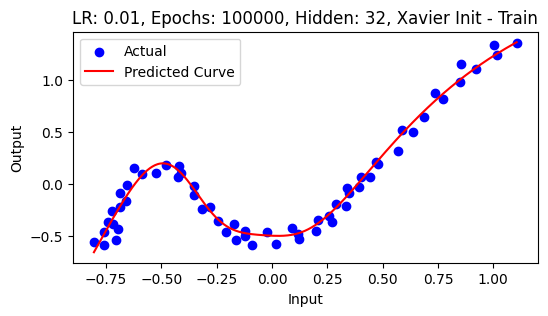

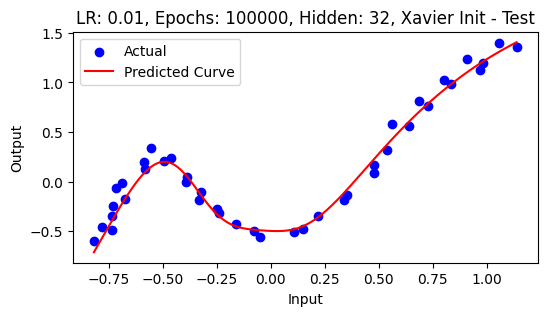

In [11]:
chosen_model = evaluate_model(32, 0.01, 100000, False, X_train_normal, Y_train_normal, X_test_normal, Y_test_normal, True, False)


Question 1c)

Choose a configuration for each hidden layer size from part a and plot them

100%|██████████| 50000/50000 [00:40<00:00, 1239.61it/s]


Hidden units: 0, Learning Rate: 0.01, Epochs: 50000, Xavier Init
Training Loss: 1448.8466, Training Loss Std: 1351.2800, Test Loss: 1771.2333, Test Loss Std: 1604.8085



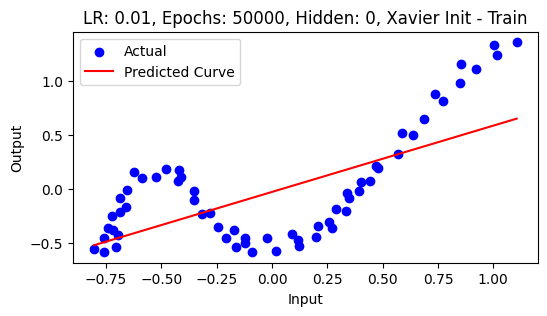

In [18]:
# hidden layer size = 0

chosen_model = evaluate_model(0, 0.01, 50000, False, X_train_normal, Y_train_normal, X_test_normal, Y_test_normal, True, True)

100%|██████████| 50000/50000 [01:10<00:00, 712.38it/s]


Hidden units: 2, Learning Rate: 0.01, Epochs: 50000, Xavier Init
Training Loss: 95.1967, Training Loss Std: 139.4146, Test Loss: 109.7300, Test Loss Std: 139.9444



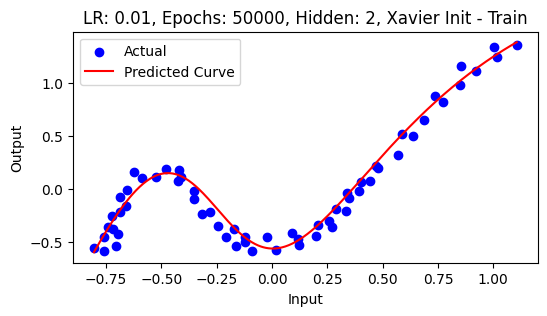

In [13]:
# hidden layer size = 2

chosen_model = evaluate_model(2, 0.01, 50000, False, X_train_normal, Y_train_normal, X_test_normal, Y_test_normal, True, True)

100%|██████████| 50000/50000 [01:09<00:00, 722.03it/s]

Hidden units: 4, Learning Rate: 0.01, Epochs: 50000, Xavier Init
Training Loss: 58.6930, Training Loss Std: 100.8040, Test Loss: 81.9962, Test Loss Std: 135.3791



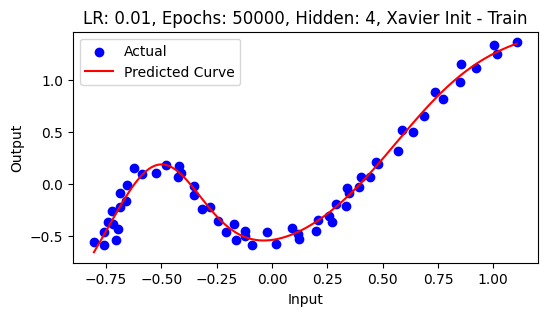

In [14]:
# hidden layer size = 4

chosen_model = evaluate_model(4, 0.01, 50000, False, X_train_normal, Y_train_normal, X_test_normal, Y_test_normal, True, True)

100%|██████████| 50000/50000 [01:09<00:00, 721.01it/s]


Hidden units: 8, Learning Rate: 0.01, Epochs: 50000, Xavier Init
Training Loss: 57.8878, Training Loss Std: 102.4545, Test Loss: 82.9415, Test Loss Std: 133.8103



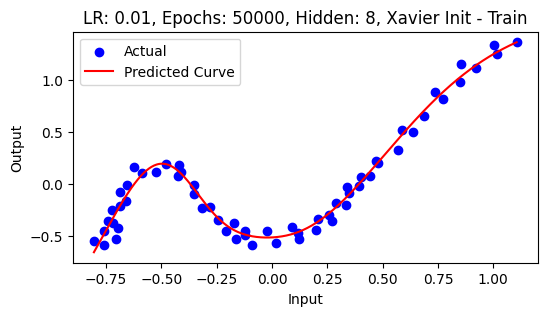

In [15]:
# hidden layer size = 8

chosen_model = evaluate_model(8, 0.01, 50000, False, X_train_normal, Y_train_normal, X_test_normal, Y_test_normal, True, True)

100%|██████████| 50000/50000 [01:10<00:00, 705.00it/s]


Hidden units: 16, Learning Rate: 0.01, Epochs: 50000, Xavier Init
Training Loss: 61.0024, Training Loss Std: 107.0224, Test Loss: 85.4658, Test Loss Std: 128.7914



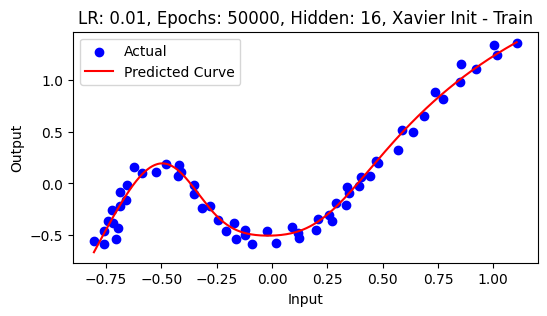

In [16]:
# hidden layer size = 16

chosen_model = evaluate_model(16, 0.01, 50000, False, X_train_normal, Y_train_normal, X_test_normal, Y_test_normal, True, True)

100%|██████████| 50000/50000 [01:10<00:00, 707.07it/s]


Hidden units: 32, Learning Rate: 0.01, Epochs: 50000, Xavier Init
Training Loss: 62.3797, Training Loss Std: 106.2808, Test Loss: 86.3040, Test Loss Std: 129.2252



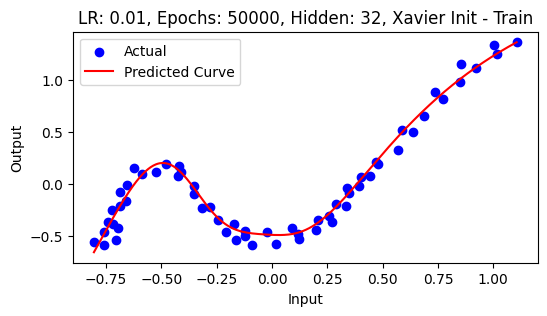

In [17]:
# hidden layer size = 32

chosen_model = evaluate_model(32, 0.01, 50000, False, X_train_normal, Y_train_normal, X_test_normal, Y_test_normal, True, True)